# Imports

In [80]:
import pandas as pd
import numpy as np
from numpy import mean
from numpy import std
import math
import time

import warnings
warnings.filterwarnings('ignore')

from sklearnex import patch_sklearn
patch_sklearn()

# Visualization
import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline
import seaborn as sns

# Feature and Model Selection
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from category_encoders import TargetEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import RandomizedSearchCV

# Models
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


# Data Loading

In [81]:
# !wget https://raw.githubusercontent.com/BKHV/risk_models/master/data/PD-data-train.csv
# !wget https://raw.githubusercontent.com/BKHV/risk_models/master/data/PD-data-test.csv
# !wget https://raw.githubusercontent.com/BKHV/risk_models/master/data/PD-data-desc.csv

In [82]:
train_df = pd.read_csv('PD-data-train.csv', sep=';')
test_df = pd.read_csv('PD-data-test.csv', sep=';')
desc_df = pd.read_csv('PD-data-desc.csv', sep=';')

In [83]:
df = pd.concat([train_df, test_df], sort=False)

# EDA

### General Information

In [84]:
print('Number of rows in test dataframe: ', test_df.shape[0])
print('Number of columns in test dataframe: ', test_df.shape[1])
print('Number of values in test dataframe: ', test_df.count().sum())
print('Number of NaNs in test dataframe: ', sum(test_df.isna().sum()))

Number of rows in test dataframe:  200
Number of columns in test dataframe:  36
Number of values in test dataframe:  4368
Number of NaNs in test dataframe:  2832


In [85]:
print('Number of rows in train dataframe: ', train_df.shape[0])
print('Number of columns in train dataframe: ', train_df.shape[1])
print('Number of values in train dataframe: ', train_df.count().sum())
print('Number of NaNs in train dataframe: ', sum(train_df.isna().sum()))

Number of rows in train dataframe:  32395
Number of columns in train dataframe:  37
Number of values in train dataframe:  835135
Number of NaNs in train dataframe:  363480


In [86]:
print('Number of rows in dataframe: ', df.shape[0])
print('Number of columns in dataframe: ', df.shape[1])
print('Number of values in dataframe: ', df.count().sum())
print('Number of NaNs in dataframe: ', sum(df.isna().sum()))

Number of rows in dataframe:  32595
Number of columns in dataframe:  37
Number of values in dataframe:  839503
Number of NaNs in dataframe:  366512


### Missing Values

In [87]:
print('Number of NaNs in train_df in all columns:\n')
count = df.isnull().sum().sort_values(ascending=False)
percentage = ((df.isnull().sum()/len(df)*100)).sort_values(ascending=False)
missing = pd.concat([count, percentage], axis=1, keys=['Count','Percentage'])
missing

Number of NaNs in train_df in all columns:



,Count,Percentage
ab_losses,15263,46.826200
ab_other_borrowings,15263,46.826200
ab_short_term_borrowing,15263,46.826200
ab_long_term_liabilities,15263,46.826200
ab_borrowed_capital,15263,46.826200
ab_own_capital,15263,46.826200
ar_revenue,15263,46.826200
ab_cash_and_securities,15263,46.826200
ab_other_current_assets,15263,46.826200
ab_accounts_receivable,15263,46.826200


### Distribution of Data Points among Output Class

In [88]:
df['default_12m'].value_counts()

0.0    30304
1.0     2091
Name: default_12m, dtype: int64

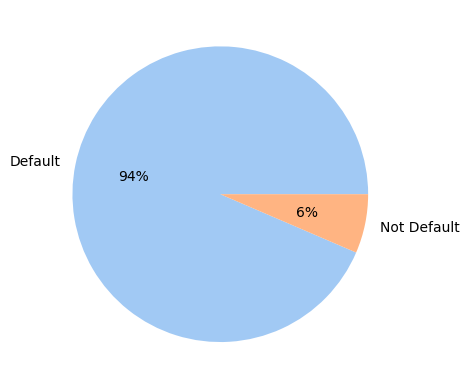

In [89]:
data = df['default_12m'].value_counts()
colors = sns.color_palette('pastel')[0:5]
labels = ['Default', 'Not Default']

plt.pie(data, labels=labels, colors=colors, autopct='%.0f%%')
plt.show()

# Data Preprocessing and Feature Selection

### Data Preprocessing

In [90]:
df = pd.concat([train_df, test_df], sort=False)

In [91]:
df.drop(['ar_revenue', 'ar_total_expenses', 'ar_sale_cost', 'ar_selling_expenses', 'ar_management_expenses',
    'ar_sale_profit', 'ar_balance_of_rvns_and_expns', 'ar_profit_before_tax', 'ar_taxes', 
    'ar_other_profit_and_losses'], axis = 1, inplace=True)

In [92]:
df['ul_systematizing_flg'].unique()

array([0])

In [93]:
df.drop(['ul_systematizing_flg'], axis = 1, inplace = True)

In [94]:
df['ul_staff_range'].unique()

array(['[1-100]', '(100-500]', '> 500'], dtype=object)

In [95]:
encoder = TargetEncoder()
df['ul_staff_range'] = encoder.fit_transform(df['ul_staff_range'], df['record_id'])

In [96]:
test_df = df.iloc[-200:,:]
train_df = df.iloc[:-200, :]
test_record_id = test_df['record_id']

In [97]:
train_df = train_df.dropna(axis=1)
test_id = test_df.dropna(axis=1)

### Deleting Duplicates

In [98]:
subset = list(train_df.columns)
subset.remove('record_id')

train_df.drop_duplicates(subset=subset, inplace = True)
train_df.drop(['record_id'], axis = 1, inplace = True)

### Feature Selection

In [99]:
X_train, X_test, y_train, y_test = train_test_split(train_df, train_df['default_12m'], test_size=0.33, random_state=1)

In [100]:
# feature selection
def select_features(X_train, y_train, X_test):
	# configure to select all features
	fs = SelectKBest(score_func=f_classif, k='all')
	# learn relationship from training data
	fs.fit(X_train, y_train)
	# transform train input data
	X_train_fs = fs.transform(X_train)
	# transform test input data
	X_test_fs = fs.transform(X_test)
	return X_train_fs, X_test_fs, fs

In [101]:
# feature selection
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)
# what are scores for the features
for i in range(len(fs.scores_)):
	print('Feature %d: %f' % (i, fs.scores_[i]))

Feature 0: 412.215324
Feature 1: 514.704698
Feature 2: 39.340626
Feature 3: 39.340626
Feature 4: 39.340626
Feature 5: 2.882164
Feature 6: 12.041601
Feature 7: 14.915588
Feature 8: 5.677987
Feature 9: 0.085072
Feature 10: inf


In [102]:
features = ['bus_age', 'ogrn_age', 'adr_actual_age', 'head_actual_age', 'cap_actual_age']

In [103]:
train_df = train_df[features]
test_df = test_df[features]

# Hyperparameter Tuning

### Random Forest

In [104]:
n_estimators = [int(x) for x in np.linspace(20, 2000, 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

In [105]:
random_grid = {'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap
}

In [106]:
rf = RandomForestClassifier()

rf_random = RandomizedSearchCV(estimator = rf,
    param_distributions = random_grid,
    n_iter = 100,
    cv = 3,
    verbose=2,
    random_state=42,
    n_jobs = -1)

rf_random.fit(train_df, train_df)

rf_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


KeyboardInterrupt: 

### Gradient Boosting

In [ ]:
learning_rate = [x for x in np.linspace(0.01, 1, 10)]
n_estimators = [int(x) for x in np.linspace(1, 200, 10)]
max_depth = [int(x) for x in np.linspace(1, 32, 32)]
min_samples_split = [int(x) for x in np.linspace(1, 50, 10)]
min_samples_leaf = [int(x) for x in np.linspace(1, 50, 10)]
max_features = [int(x) for x in np.linspace(1, 15, 15)]

In [ ]:
random_grid = {'learning_rate': learning_rate,
    'n_estimators': n_estimators,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'max_features': max_features
}

In [ ]:
gb = GradientBoostingClassifier()

gb_random = RandomizedSearchCV(estimator = gb,
    param_distributions = random_grid,
    n_iter = 100,
    cv = 3,
    verbose=2,
    random_state=42,
    n_jobs = -1)

# gb_random.fit(train_df.drop(['default_12m', 'record_id'], axis=1), train_df['default_12m'])

gb_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END learning_rate=0.34, max_depth=17, max_features=13, min_samples_leaf=39, min_samples_split=22, n_estimators=67; total time=   0.0s
[CV] END learning_rate=0.34, max_depth=17, max_features=13, min_samples_leaf=39, min_samples_split=22, n_estimators=67; total time=   0.0s
[CV] END learning_rate=0.34, max_depth=17, max_features=13, min_samples_leaf=39, min_samples_split=22, n_estimators=67; total time=   0.0s
[CV] END learning_rate=0.89, max_depth=31, max_features=15, min_samples_leaf=28, min_samples_split=39, n_estimators=45; total time=   0.0s
[CV] END learning_rate=0.89, max_depth=31, max_features=15, min_samples_leaf=28, min_samples_split=39, n_estimators=45; total time=   0.0s
[CV] END learning_rate=0.89, max_depth=31, max_features=15, min_samples_leaf=28, min_samples_split=39, n_estimators=45; total time=   0.0s
[CV] END learning_rate=0.45, max_depth=21, max_features=15, min_samples_leaf=22, min_samples_split=44, 

{'n_estimators': 67,
 'min_samples_split': 50,
 'min_samples_leaf': 11,
 'max_features': 3,
 'max_depth': 4,
 'learning_rate': 0.23}

### CatBoost

In [ ]:
learning_rate = [x for x in np.linspace(0.001, 0.01, 50)]
depth = [x for x in np.linspace(4, 10, 7)]
l2_leaf_reg = [x for x in np.linspace(2, 10, 9)]
random_strength = [x for x in np.linspace(0, 10, 11)]

In [ ]:
random_grid = {'learning_rate': learning_rate,
    'depth': depth,
    'l2_leaf_reg': l2_leaf_reg,
    'random_strength': random_strength
}

In [ ]:
cb = CatBoostClassifier(silent=True)

cb_random = RandomizedSearchCV(estimator = cb,
    param_distributions = random_grid,
    n_iter = 100,
    cv = 3,
    verbose=2,
    random_state=42,
    n_jobs = -1)

cb_random.fit(train_df.drop(['default_12m', 'record_id'], axis=1), train_df['default_12m'])

cb_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END depth=4.0, l2_leaf_reg=3.0, learning_rate=0.0061428571428571435, random_strength=2.0; total time=   8.1s
[CV] END depth=4.0, l2_leaf_reg=3.0, learning_rate=0.0061428571428571435, random_strength=2.0; total time=   8.1s
[CV] END depth=6.0, l2_leaf_reg=4.0, learning_rate=0.005591836734693878, random_strength=9.0; total time=   9.9s
[CV] END depth=7.0, l2_leaf_reg=3.0, learning_rate=0.007428571428571429, random_strength=10.0; total time=  11.2s
[CV] END depth=7.0, l2_leaf_reg=3.0, learning_rate=0.007428571428571429, random_strength=10.0; total time=  11.4s
[CV] END depth=7.0, l2_leaf_reg=3.0, learning_rate=0.007428571428571429, random_strength=10.0; total time=  11.8s
[CV] END depth=4.0, l2_leaf_reg=3.0, learning_rate=0.0061428571428571435, random_strength=2.0; total time=  12.4s
[CV] END depth=6.0, l2_leaf_reg=4.0, learning_rate=0.005591836734693878, random_strength=9.0; total time=  13.1s
[CV] END depth=5.0, l2_leaf

KeyboardInterrupt: 

### GaussianNB

In [ ]:
random_grid = {'var_smoothing': np.logspace(0,-9, num=100)}

gnb = GaussianNB()

gnb_random = RandomizedSearchCV(estimator = gnb,
    param_distributions = random_grid,
    n_iter = 100,
    cv = 3,
    verbose=2,
    random_state=42,
    n_jobs = -1)

gnb_random.fit(train_df.drop(['default_12m', 'record_id'], axis=1), train_df['default_12m'])

gnb_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END ..................................var_smoothing=1.0; total time=   0.0s
[CV] END ..................................var_smoothing=1.0; total time=   0.0s
[CV] END ..................................var_smoothing=1.0; total time=   0.0s
[CV] END ...................var_smoothing=0.8111308307896871; total time=   0.0s
[CV] END ...................var_smoothing=0.8111308307896871; total time=   0.0s
[CV] END ...................var_smoothing=0.8111308307896871; total time=   0.0s
[CV] END ....................var_smoothing=0.657933224657568; total time=   0.0s
[CV] END ....................var_smoothing=0.657933224657568; total time=   0.0s
[CV] END ....................var_smoothing=0.657933224657568; total time=   0.0s
[CV] END ....................var_smoothing=0.533669923120631; total time=   0.0s
[CV] END ....................var_smoothing=0.533669923120631; total time=   0.0s
[CV] END ....................var_smoothing=0.5

# Modelling and Evaluation

In [ ]:
# Get a stacking ensemble of models
def get_stacking():
    # Defining the base models
    level0 = list()
    level0.append(('RandomForest', RandomForestClassifier()))
    level0.append(('GradientBoosting', GradientBoostingClassifier()))
    level0.append(('CatBoost', CatBoostClassifier(silent=True)))
    level0.append(('GaussianNB', GaussianNB()))
    # Defining meta learner model
    level1 = LogisticRegression()
    # Defining the stacking ensemble
    model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
    return model

In [ ]:
# Evaluate a given model using cross-validation
def roc_auc_evaluate_model(model, x, y):
    start_time = time.time()
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, x, y, scoring='roc_auc', cv=cv, n_jobs=-1, error_score='raise')
    run_time = time.time() - start_time
    return scores, run_time

In [ ]:
# Get the models to evaluate
name = 'Stacking'
model = get_stacking()
roc_auc_results, names, runs = list(), list(), list()

# Evaluate the models and store results
roc_auc_scores, run_time = roc_auc_evaluate_model(model, train_df.drop('default_12m', axis=1), train_df['default_12m'])
roc_auc_results.append(roc_auc_scores)
names.append(name)
runs.append(run_time)
print(name, "| ROC AUC:", mean(roc_auc_scores), "| Standard Deviation:", std(roc_auc_scores),"| Time Taken:", run_time)

# Results

In [ ]:
answ_df = pd.DataFrame()
answ_df['id'] = test_record_id
predict = pd.DataFrame([math.floor(float(x)) for x in (predictions*100)])
answ_df['predict'] = predict
answ_df.to_csv('PD-submit.csv',index=False, sep=';')